# Sequence Learning - Direct - English - Testing Session - Boundary Prediction
Version 2: encode all validation set tokens, but keeping only those that are "matching" (= match_status==1)

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import plotly.express as px
import random
from sklearn.manifold import TSNE  # Optional: Use t-SNE for dimensionality reduction
import seaborn as sns
from collections import Counter

In [2]:
from padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from my_utils import *
from loss import *
from model import SimplerPhxLearner, LHYPhxLearner, TwoLinPhxLearner
from dataset import SeqDatasetBoundary, MelSpecTransformNewNew, Normalizer, DeNormalizer
from my_dataset import DS_Tools
from reshandler import BndEncoderResHandler
from misc_progress_bar import draw_progress_bar
from bnd_detect_tools import *

## Preps

### Dirs

In [3]:
model_save_dir = model_eng_save_dir

log_path = compound_word_log_path
rec_path = word_seg_anno_path

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Model

### Model-related defs

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

# model = SimplerPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
# model = LHYPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model = TwoLinPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [9]:
load_ts = "0122150900"
stop_epoch = "12"

In [10]:
model_raw_name = "PT_{}_{}_full".format(load_ts, stop_epoch)
model_name = model_raw_name + ".pt"
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

TwoLinPhxLearner(
  (encoder): LRLEncoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=64, out_features=32, bias=True)
      (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (rnn): LSTM(32, 16, num_layers=2, batch_first=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): LRALDecoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=64, out_features=32, bias=True)
      (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (rnn): LSTM(32, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): Linear(in_features=8, out_fe

### Dataset

- Note that due to the separate setting of word and phone datasets, we cannot really make it to select those that have not been trained on 
for this test. This is a point to further fix. Make reference to out first work. 

In [11]:
valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(load_ts)))

In [12]:
logdf = pd.read_csv(os.path.join(log_path, "log.csv"))

In [13]:
val = logdf.loc[valid_ds_indices]
val = val[val["match_status"] == 1]

In [14]:
train = logdf.loc[~logdf.index.isin(valid_ds_indices)]
train = train[train["match_status"] == 1]

In [15]:
# Apply the time_to_rel_frame function to the column
val["time_to_rel_frame"] = val.apply(time_to_rel_frame, axis=1)

# Filter out rows with len <= 1
over_one_count = (val["time_to_rel_frame"].apply(len) > 1).sum()

# Calculate the ratio
total_rows = len(val)
ratio = over_one_count / total_rows

print(f"Ratio of 'match status' being 1: {ratio}")

Ratio of 'match status' being 1: 0.8672523677728969


In [16]:
# Apply the time_to_rel_frame function to the column
train["time_to_rel_frame"] = train.apply(time_to_rel_frame, axis=1)

# Filter out rows with len <= 1
over_one_count = (train["time_to_rel_frame"].apply(len) > 1).sum()

# Calculate the ratio
total_rows = len(train)
ratio = over_one_count / total_rows

print(f"Ratio of 'match status' being 1: {ratio}")

Ratio of 'match status' being 1: 0.8690108387358185


In [18]:
# mytrans = MelSpecTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)
mytrans = MelSpecTransformNewNew(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS, normalizer=Normalizer.norm_mvn, denormalizer=DeNormalizer.norm_mvn)
ds = SeqDatasetBoundary(rec_path, os.path.join(log_path, "log.csv"), transform=mytrans)

# Cannot load dataset trained, data filtering applied
valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid_ds_{}.pkl".format(load_ts)))

valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

# # this is to reduce the size of the dataset when the training power is not sufficient
# small_len = int(0.5 * len(ds))
# other_len = len(ds) - small_len

# # Randomly split the dataset into train and validation sets
# valid_ds, other_ds = random_split(ds, [small_len, other_len])

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=SeqDatasetBoundary.collate_fn)
valid_num = len(valid_loader.dataset)

In [19]:
valid_num

56808

## Inference

In [20]:
def infer(): 
    model.eval()
    reshandler = BndEncoderResHandler(whole_res_dir=compound_plot_res_path, file_prefix=model_raw_name)
    all_res = []
    all_bnd = []
    all_name = []
    all_ms = []

    total = len(valid_loader)

    for idx, (x, x_lens, bnd, name, ms) in enumerate(valid_loader): 
        bnd = bnd[0]
        name = name[0]
        ms = ms[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        hid_r = model.encode(x, x_lens, x_mask)

        hid_r = hid_r.cpu().detach().numpy().squeeze()

        length = hid_r.shape[0]

        all_res += [hid_r]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        all_bnd += [bnd]
        all_name += [name]
        all_ms += [ms]

        if idx % 10 == 0: 
            draw_progress_bar(idx, total)
    

    reshandler.res = all_res
    reshandler.tok = all_bnd
    reshandler.name = all_name
    reshandler.match_status = all_ms
    reshandler.save()

In [21]:
if __name__ == "__main__": 
    infer()

[==================================================] 99%	

# Load Res

In [22]:
reshandler = BndEncoderResHandler(whole_res_dir=compound_plot_res_path, file_prefix=model_raw_name)
reshandler.read()

# Evaluate with Wang et al. method

In [23]:
# all
all_preds = reshandler.res
all_bnds = reshandler.tok
all_matching_status = reshandler.match_status

In [24]:
mismatch_counter = 0
total_counter = 0

for ms in all_matching_status: 
    if ms != 1: 
        mismatch_counter += 1
    total_counter += 1

print(mismatch_counter, total_counter, mismatch_counter/total_counter)

17326 56808 0.30499225461202645


In [25]:
# mismatcher_out: exclude those that are not matching
preds_misout = []
bnds_misout = []
for idx in range(len(all_preds)): 
    if all_matching_status[idx] != 1: 
        continue
    preds_misout.append(all_preds[idx])
    bnds_misout.append(all_bnds[idx])

In [26]:
len(preds_misout)

39482

In [27]:
one_counter = 0
total_counter = 0

for bnd in bnds_misout: 
    if len(bnd) <= 1: 
        one_counter += 1
    total_counter += 1

print(one_counter, total_counter, one_counter/total_counter)

5093 39482 0.1289954916164328


In [28]:
# one_bound_out: bnds excludes last
preds = []
bnds = []
for idx in range(len(preds_misout)): 
    if len(bnds_misout[idx]) <= 1: 
        continue
    preds.append(preds_misout[idx])
    bnds.append(bnds_misout[idx][:-1])

In [29]:
len(bnds)

34389

In [30]:
periodic_preds = periodic_bnd_detect(preds, every=4, only_then_rand=False)

In [31]:
pb_precision_list, pb_recall_list = [], []

#Recall
for i in range(len(bnds)):
    single_utt_recall = tolerance_recall(bnds[i], \
                            periodic_preds[i], tolerance_window=2)
    pb_recall_list.append(single_utt_recall)

#Precision
for i in range(len(periodic_preds)):
    single_utt_precision = tolerance_precision(bnds[i], \
                            periodic_preds[i], tolerance_window=2)
    pb_precision_list.append(single_utt_precision)


precision = sum(pb_precision_list) / len(pb_precision_list)
recall = sum(pb_recall_list) / len(pb_recall_list)
recall *= 100
precision *= 100
if recall == 0. or precision == 0.:
    f_score = -1.
    r_val = -1.
else:
    f_score = (2 * precision * recall) / (precision + recall)
    r_val = r_val_eval(precision, recall)

print("R-value for periodic boundary prediction is: {}".format(r_val))

R-value for periodic boundary prediction is: 39.55647345222224


## Run a through search through all dims

In [32]:
dims = list(range(8)) + ["mean"]
th = [0.1, 0.08, 0.06, 0.05, 0.04, 0.035, 0.03]
th += [0.029, 0.028, 0.027, 0.026, 0.025, 0.024, 0.023, 0.022, 0.021, 0.02, 0.019]
th += [0.018, 0.017, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011, 0.01]
th += [0.0008, 0.0007]
th_total = len(th)

recall_lslsls, precision_lslsls, r_val_lslsls = [], [], []

for idx, dim in enumerate(dims): 
    recall_lsls, precision_lsls, r_val_ls = [], [], []
    
    for idx, thresh in enumerate(th): 
        recall_list, precision_list = thresh_segmentation_eval(batch_delta_hrs(preds, sel=dim, minus=True), bnds, tolerance_window=2, diff_thresh_factor=thresh)
        recall_lsls.append(recall_list)
        precision_lsls.append(precision_list)

    for th_idx in range(len(th)): 
        precision_list = precision_lsls[th_idx]
        recall_list = recall_lsls[th_idx]

        precision = sum(precision_list) / len(precision_list)
        recall = sum(recall_list) / len(recall_list)
        recall *= 100
        precision *= 100
        if recall == 0. or precision == 0.:
            f_score = -1.
            r_val = -1.
        else:
            f_score = (2 * precision * recall) / (precision + recall)
            r_val = r_val_eval(precision, recall)
        
        r_val_ls.append(r_val)
    
    recall_lslsls.append(recall_lsls)
    precision_lslsls.append(precision_lsls)
    r_val_lslsls.append(r_val_ls)
    
    print('The best r_val is: {:.4f}, th = {}, dim = {}'.format(max(r_val_ls), th[r_val_ls.index(max(r_val_ls))], dim))

The best r_val is: 58.9994, th = 0.1, dim = 0
The best r_val is: 47.2269, th = 0.1, dim = 1
The best r_val is: 52.4571, th = 0.1, dim = 2
The best r_val is: 58.5722, th = 0.013, dim = 3
The best r_val is: 62.7765, th = 0.1, dim = 4
The best r_val is: 52.8489, th = 0.08, dim = 5
The best r_val is: 30.8309, th = 0.0007, dim = 6
The best r_val is: 58.7593, th = 0.1, dim = 7
The best r_val is: 60.5691, th = 0.019, dim = mean


In [59]:
# Plus
"""
The best r_val is: 64.1704, th = 0.027, dim = 0
The best r_val is: 29.5702, th = 0.0008, dim = 1
The best r_val is: 62.8208, th = 0.019, dim = 2
The best r_val is: 64.6059, th = 0.03, dim = 3
The best r_val is: 49.6899, th = 0.003, dim = 4
The best r_val is: 67.6130, th = 0.008, dim = 5
The best r_val is: 35.5558, th = 0.0008, dim = 6
The best r_val is: 63.5690, th = 0.022, dim = 7
The best r_val is: 55.5981, th = 0.0008, dim = mean
"""

# Minus
"""
The best r_val is: 65.9907, th = 0.024, dim = 0
The best r_val is: 51.9334, th = 0.035, dim = 1
The best r_val is: 62.7616, th = 0.01, dim = 2
The best r_val is: 65.6081, th = 0.03, dim = 3
The best r_val is: 49.1389, th = 0.0008, dim = 4
The best r_val is: 65.7445, th = 0.01, dim = 5
The best r_val is: 65.8716, th = 0.027, dim = 6
The best r_val is: 63.0764, th = 0.019, dim = 7
The best r_val is: 66.7116, th = 0.027, dim = mean
"""


"""
The best r_val is: 64.1667, th = 0.028, dim = 0
The best r_val is: 29.5675, th = 0.001, dim = 1
The best r_val is: 62.7918, th = 0.02, dim = 2
The best r_val is: 64.6059, th = 0.03, dim = 3
The best r_val is: 49.6220, th = 0.004, dim = 4
The best r_val is: 67.6130, th = 0.008, dim = 5
The best r_val is: 35.5199, th = 0.001, dim = 6
The best r_val is: 63.5690, th = 0.022, dim = 7
The best r_val is: 55.5489, th = 0.001, dim = mean
"""

'\nThe best r_val is: 64.1667, th = 0.028, dim = 0\nThe best r_val is: 29.5675, th = 0.001, dim = 1\nThe best r_val is: 62.7918, th = 0.02, dim = 2\nThe best r_val is: 64.6059, th = 0.03, dim = 3\nThe best r_val is: 49.6220, th = 0.004, dim = 4\nThe best r_val is: 67.6130, th = 0.008, dim = 5\nThe best r_val is: 35.5199, th = 0.001, dim = 6\nThe best r_val is: 63.5690, th = 0.022, dim = 7\nThe best r_val is: 55.5489, th = 0.001, dim = mean\n'

# Plot some hidrep graphs in relation to boundary

In [33]:
def plot_feature_with_boundaries(features, boundaries, name):
    num_features = features.shape[1]
    num_samples = features.shape[0]

    time_axis = np.arange(num_samples)

    fig, axes = plt.subplots(num_features + 1, 1, figsize=(10, (num_features + 1) * 2), sharex=True)

    # Plot each feature on separate subplots
    for i in range(num_features):
        ax = axes[i]
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}')

        for boundary in boundaries:
            if boundary < num_samples:
                ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

        ax.set_ylabel(f'Feature {i + 1}')

    # Plot all dimensions together with different line colors
    ax = axes[num_features]
    for i in range(num_features):
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}', alpha=0.5)

    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    ax.set_ylabel('All Features')
    ax.legend()

    plt.xlabel('Time (frames)')

    plt.tight_layout()
    # plt.show()
    plt.savefig("./8dim_hrs/" + "{}_dim.png".format(name))
    plt.close()

In [34]:
def plot_mean_feature_with_boundaries(features, boundaries, name):
    """
    Plot the mean of the features as a line graph with marked boundaries.
    
    Parameters:
    - features: NumPy array of shape (length, 8)
    - boundaries: List of boundary times (frame numbers)
    """
    num_samples = features.shape[0]

    # Create a time axis
    time_axis = np.arange(num_samples)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, features, label='Mean Feature')

    # Mark boundaries on the plot
    for boundary in boundaries:
        if boundary < num_samples:
            plt.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    # Set labels and legend
    plt.xlabel('Time (frames)')
    plt.ylabel('Mean Feature Value')
    plt.legend()
    
    # plt.show()
    plt.savefig("./8dim_hrs/" + "{}_mean.png".format(name))
    plt.close()

In [50]:
def plot_all_and_mean_feature_with_boundaries(features, mean_features, boundaries, name):
    """
    Plot the mean of the features as a line graph with marked boundaries.
    
    Parameters:
    - features: NumPy array of shape (length, 8)
    - boundaries: List of boundary times (frame numbers)
    """
    num_features = features.shape[1]
    num_samples = features.shape[0]

    # Create a time axis
    time_axis = np.arange(num_samples)

    # Create the plot
    # plt.figure(figsize=(10, 6))
    fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
    # Plot all dimensions together with different line colors

    ax = axes[0]
    ax.plot(time_axis, mean_features, label='Mean Feature')

    # Mark boundaries on the plot
    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    ax.set_ylabel('Mean Feature Value')

    ax = axes[1]
    for i in range(num_features):
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}', alpha=0.5)

    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)
    
    ax.set_ylabel('All Features')
    # ax.legend(loc="best")

    # Set labels and legend
    plt.xlabel('Time (frames)')
    
    # plt.legend(pos="out")
    
    plt.show()
    # plt.savefig("./8dim_hrs/" + "{}_mean.png".format(name))
    # plt.close()

In [51]:
spec_idx = reshandler.name.index("s0402b_00000868")

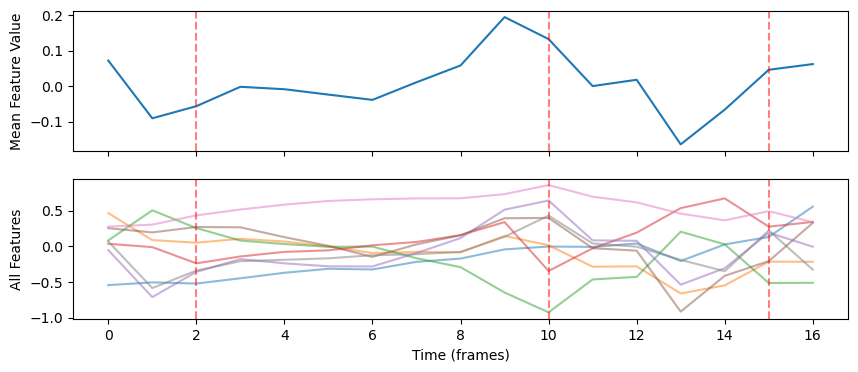

In [52]:
name = reshandler.name[spec_idx]
pred = reshandler.res[spec_idx]
bnd = reshandler.tok[spec_idx]

delta = delta_hrs(pred)
pred_mean = pred.mean(axis=1)
delta_mean = delta_hrs(pred_mean)
# delta = pred
plot_all_and_mean_feature_with_boundaries(delta, delta_mean, bnd, name)

In [23]:
mk("./8dim_hrs")

In [24]:
total_len = len(reshandler.name)

In [26]:
spec_idx = reshandler.name.index("s0502a_00000395")

In [27]:
name = reshandler.name[spec_idx]
pred = reshandler.res[spec_idx]
bnd = reshandler.tok[spec_idx]

delta = delta_hrs(pred)
# delta = pred
plot_feature_with_boundaries(delta, bnd, name)

pred_mean = pred.mean(axis=1)
delta = delta_hrs(pred_mean)
# delta = pred_mean
plot_mean_feature_with_boundaries(delta, bnd, name)

In [25]:
for i in range(20): 
    randidx = random.randint(0, total_len)
    name = reshandler.name[randidx]
    pred = reshandler.res[randidx]
    bnd = reshandler.tok[randidx]

    # delta = delta_hrs(pred)
    delta = pred
    plot_feature_with_boundaries(delta, bnd, name)

    pred_mean = pred.mean(axis=1)
    # delta = delta_hrs(pred_mean)
    delta = pred_mean
    plot_mean_feature_with_boundaries(delta, bnd, name)